In [1]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import re
from tqdm import trange
import copy
import tarfile
import soundfile as sf
import wget

In [2]:
params = {}
params["target_steps"] = 1000
params["num_bands"] = 80
params["num_classes"] = 35
params["sample_rate"] = 16000
params["pre_emphasis"] = 0.95
params["frame_length"] = 0.025
params["hop_length"] = 0.001
params["fft_size"] = 512
params["scale_value"] = 0.0009
params["save_directory_name"] = "rawSC_80input"

In [3]:
### (1) download and allocate folders for google speech commands dataset ###

# get a directory to download and encode dataset files
directory = os.path.expanduser("~/data")

try:
    os.makedirs(directory)
except:
    pass
os.chdir(directory)

try:
    os.makedirs("rawSC")
except:
    pass
os.chdir("rawSC")

if not os.path.exists("speech_commands_v0.02.tar.gz"):
    print("downloading dataset")
    wget.download("http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz")

# unzip to folder
if not os.path.isdir("speech_commands_extracted"):
    # downloading the 35 classes version
    file = tarfile.open("speech_commands_v0.02.tar.gz")

    file.extractall("./speech_commands_extracted")

    file.close()

os.chdir("speech_commands_extracted")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawSC/speech_commands_extracted


In [4]:
### (2) sort through dataset to get testing/validation/training ###

# load GSC validation and training data list
# load a list of training audio files
validation_files = []
with open("validation_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        validation_files.append(x)
        
# load a list of testing audio files
test_files = []
with open("testing_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        test_files.append(x)

# load classes and assign labels
folders = os.listdir()
exception = ["validation_list.txt",
             "_background_noise_",
             ".DS_Store",
             "README.md",
             "LICENSE",
             "testing_list.txt"]

assert len(list(set(folders) - set(exception))) == params["num_classes"]

classes = np.sort(list(set(folders) - set(exception)))

classes_and_labels = {}

for i, c in enumerate(classes):
    classes_and_labels[c] = i


In [5]:
### (3) Mel Spectrogram encoding ###

def to_mel_spectrogram(file_name,
                       params, 
                       display = False):
    
    audio, sr = librosa.load(file_name, sr = params["sample_rate"], mono=True)
    
    # Apply pre-emphasis filter
    emphasized_audio = np.append(audio[0], 
                                 audio[1:] - params["pre_emphasis"] * audio[:-1])

    # Define frame length and stride in samples
    frame_length = int(sr * params["frame_length"])  # 25ms
    hop_length = int(sr * params["hop_length"])  # 10ms

    # Compute the power spectrum using a 512-point FF
    power_spectrum = np.abs(librosa.stft(emphasized_audio, 
                                         n_fft = params["fft_size"], 
                                         hop_length = hop_length, 
                                         win_length = frame_length))**2

    # Compute the filter banks with 40 triangular filters
    filter_banks = librosa.filters.mel(n_fft = params["fft_size"], 
                                       sr = sr, 
                                       n_mels = params["num_bands"])

    # Apply the filter banks to the power spectrum
    mel_spec = np.dot(filter_banks, power_spectrum)

    # Crop or pad to 80 steps by repeating the last frame
    current_steps = mel_spec.shape[1]
    if current_steps < params["target_steps"]:
        padding = np.zeros((params["num_bands"], params["target_steps"] - current_steps))
        mel_spec = np.hstack((mel_spec, padding))
    elif current_steps > params["target_steps"]:
        mel_spec = mel_spec[:, :params["target_steps"]]

    # Convert power spectrogram to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if display:
        # Display the filter banks with the 'viridis' colormap
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Filter Banks with Pre-Emphasis Filter (Cropped/Padded to 80 Steps)')
        plt.tight_layout()
        plt.show()
        
        print(mel_spec_db.shape)
    
    else:
        return mel_spec_db

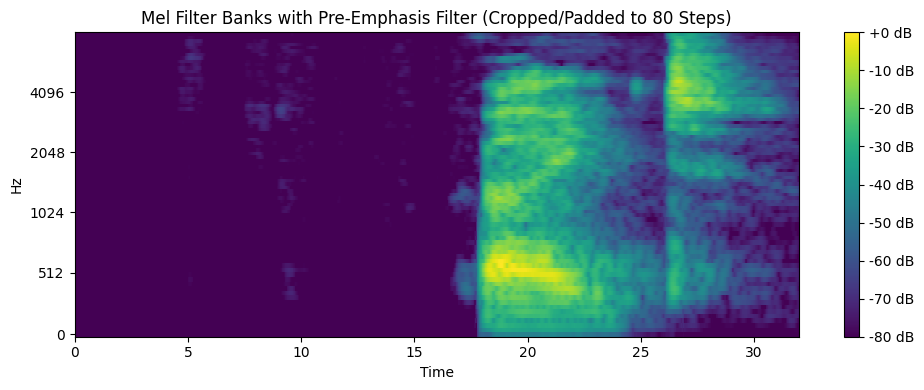

(80, 1000)
10


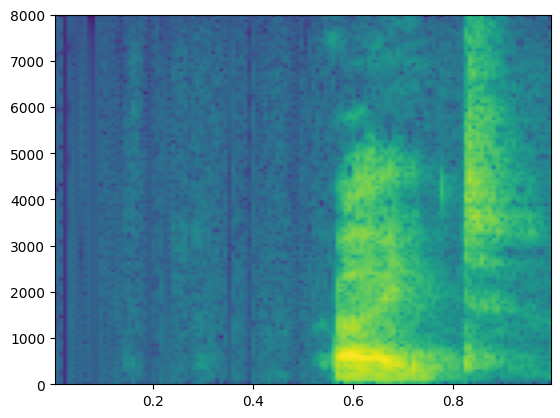

(16000,)


In [6]:
# Visualise the output of the mel encoding
rnd_val = 10#np.random.randint(0, len(test_files))
test_image = test_files[rnd_val]
to_mel_spectrogram(test_image, params, True)
print(rnd_val)

# Visualise the same input but on soecgram (visual check)
data, samplerate = sf.read(test_image)  
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
plt.show()
print(data.shape)

In [7]:
### (4) loop through audio and convert to Mel Encoding ###

# Get all files to loop through
all_files = []
for folder in list(set(folders) - set(exception)):
    files_in_folder = os.listdir(folder)
    for sound_file in files_in_folder:
        all_files.append(folder + "/" + sound_file)

training_y_data, testing_y_data, validation_y_data = [], [], []
len_training_files = len(all_files) - (len(test_files) + len(validation_files))

training_x_data = np.zeros((len_training_files, 
                            params["num_bands"], 
                            params["target_steps"]),  
                            dtype = np.float32)
testing_x_data = np.zeros((len(test_files), 
                           params["num_bands"], 
                           params["target_steps"]),  
                           dtype = np.float32)
validation_x_data = np.zeros((len(validation_files), 
                              params["num_bands"], 
                              params["target_steps"]),  
                              dtype = np.float32)

validation_count, testing_count, training_count = 0, 0, 0

# save all to a list
for i in trange(len(all_files)):
    if all_files[i] in validation_files:
        validation_x_data[validation_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i], params)))
        validation_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        validation_count += 1

    if all_files[i] in test_files:
        testing_x_data[testing_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i], params)))
        testing_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        testing_count += 1
        
    if all_files[i] not in test_files and all_files[i] not in validation_files:
        training_x_data[training_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i], params)))
        training_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        training_count += 1

assert len(test_files) == testing_count
assert len(validation_files) == validation_count 
assert (len(all_files) - (len(test_files) + len(validation_files))) == training_count

print(f"training data size:     {training_count}\t out of {len_training_files}")
print(f"testing data size:      {testing_count}\t out of {len(test_files)}")
print(f"validation data size:   {validation_count}\t out of {len(validation_files)}")

100%|██████████| 105829/105829 [07:01<00:00, 251.32it/s]

training data size:     84843	 out of 84843
testing data size:      11005	 out of 11005
validation data size:   9981	 out of 9981


In [8]:
### (5) Preprocess dataset with scaling and transposing

# save dataset
os.chdir(directory)
# create new directory for raw HD
assert os.path.isdir("rawSC") == True
os.chdir("rawSC")

try:
    os.mkdir(params["save_directory_name"])
except:
    pass
  
os.chdir(params["save_directory_name"])
print("current cwd", os.getcwd())

print("pre processing data...")
# data processing
training_x_data = np.swapaxes(training_x_data, 1, 2) 
testing_x_data = np.swapaxes(testing_x_data, 1, 2) 
validation_x_data = np.swapaxes(validation_x_data, 1, 2) 

# move values into positive
training_x_data -= training_x_data.min()
testing_x_data -= testing_x_data.min()
validation_x_data -= validation_x_data.min()

# scale values 
training_x_data *= params["scale_value"]
testing_x_data = testing_x_data * params["scale_value"]
validation_x_data = validation_x_data * params["scale_value"]

current cwd /its/home/ts468/data/rawSC/rawSC_80input
pre processing data...


In [9]:
### (6) save dataset as npy ###

np.save("training_x_data.npy", training_x_data)
np.save("training_y_data.npy", training_y_data)
np.save("testing_y_data.npy", testing_y_data)
np.save("testing_x_data.npy", testing_x_data)
np.save("validation_y_data.npy", validation_y_data)
np.save("validation_x_data.npy", validation_x_data)

print("files saved:")
print(os.listdir())

files saved:
['training_x_data.npy', 'validation_y_data.npy', 'validation_x_data.npy', 'testing_x_data.npy', 'training_y_data.npy', 'testing_y_data.npy']
